<a href="https://colab.research.google.com/github/chenscheim97/iPIPE/blob/main/signal_sample_analysis_EXP0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Set Up**
1.   while running for the first time you'll need to let google colab access to the drive
2.   follow the pop up windows instructions
3.   make sure you sign in via the google account you signed with to the IPIPE drive

**imports**

In [2]:
import numpy as np   # The fundamental package for scientific computations
import matplotlib.pyplot as plt   # a basic plotting package, based on the MATLAB plotting scheme
from google.colab import drive
import os
from scipy.fft import fft, fftfreq
from scipy.signal import find_peaks
import binascii


**functions**

In [57]:
def time_fixer(item):
  if item.endswith('uS'):
    return float(item[:-2]) * 10**-6  # us

  elif item.endswith('mS'):
    return float(item[:-2]) * 10**-3  # ms

def binary_to_ascii(binary_str):
    decimal_value = int(binary_str, 2)
    ascii_char = chr(decimal_value)
    return ascii_char

def sample_formating(_raw, channel, clock, size, units):
  """
  this funciton gets the raw data and returns the relavent parameters from the
  data

  input: _raw as string
  output: channel, clock, size, units
  """
  rows = _raw.split("\n")
  rows.remove('')
  channel = str_helper(rows[0])
  clock = time_fixer(str_helper(rows[1]))
  size = int(str_helper(rows[2]))
  units = str_helper(rows[3])
  return np.array([float(i) for i in rows[4:4+size]]), channel, clock, size, units

def time_fixer(item):
  if item.endswith('uS'):
    return float(item[:-2]) * 10**-6  # us

  elif item.endswith('mS'):
    return float(item[:-2]) * 10**-3  # ms

def sample_formating(_raw, channel, clock, size, units):
  """
  this funciton gets the raw data and returns the relavent parameters from the
  data

  input: _raw as string
  output: channel, clock, size, units
  """
  rows = _raw.split("\n")
  rows.remove('')
  channel = str_helper(rows[0])
  clock = time_fixer(str_helper(rows[1]))
  size = int(str_helper(rows[2]))
  units = str_helper(rows[3])
  return np.array([float(i) for i in rows[4:4+size]]), channel, clock, size, units

def detect_jump(arr):
  # detecting the length of a one bit in the message
  for i in range(1, len(arr)):
    if arr[i] != (arr[i-1] + 1):
      return i - 1
  return None

def rms_thresh(signal) :
  """
  returning a numpy object with binary representation of the data
  """
  # Assuming you have the noisy signal "volts"
  # RMS thresholding to extract the binary message
  window_length = 45  # Adjust as needed
  hw = (window_length - 1) // 2
  sig_RMS = np.zeros(len(signal))
  sig_zero_padded = np.concatenate((np.zeros(hw), signal, np.zeros(hw)))

  sig_zero_padded = sig_zero_padded ** 2
  for i in range(hw, len(sig_zero_padded) - hw):
    sig_RMS[i - hw] = np.sqrt(np.mean(sig_zero_padded[i - hw : i + hw + 1]))

  # threshold = 0.32
  threshold = 0.5
  trigger = np.max(signal) * threshold  # Adjust the threshold as needed
  normalize = np.max(signal)*0.85  # 85% from the max peak
  binary_extracted = (sig_RMS > trigger).astype(int)
  return trigger, normalize, binary_extracted

def str_helper(item):
  if ":" in item:
    return item.split(":")[-1]
  elif "=" in item:
    return item.split("=")[-1]

transfer func

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


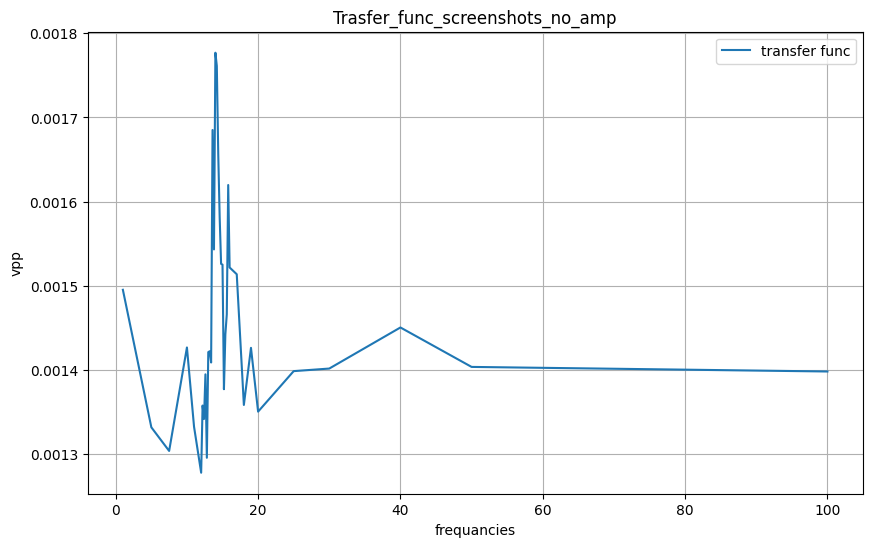

In [61]:
def calc_vpp(volts):
  trigger, normalize, binary_extracted = rms_thresh(volts)
  # Find all positive peaks above the threshold
  positive_peaks = volts[volts > trigger]

  # Find all negative troughs below the negative of the threshold
  negative_troughs = volts[volts < -trigger]

  # Calculate the average of positive peaks and negative troughs

  if positive_peaks.any():
    avg_positive_peak = np.mean(positive_peaks)
  else:
    avg_positive_peak = 0

  if negative_troughs.any():
    avg_negative_trough = np.mean(negative_troughs)
  else:
    avg_negative_trough = 0

  # Calculate peak-to-peak voltage
  peak_to_peak_voltage = abs(avg_positive_peak - avg_negative_trough)

  # print("Peak-to-Peak Voltage:", peak_to_peak_voltage)
  return peak_to_peak_voltage

normed = '/content/drive'
drive.mount(normed)

# sig_path = normed+"/MyDrive/IPIPE/Experiments/Exp0/with_x10_amp"
sig_path = normed+"/MyDrive/IPIPE/Experiments/Exp0/Trasfer_func_screenshots_no_amp"

samples = os.listdir(sig_path)

freq = []
vpps = []
for index, samp in enumerate(samples):
  samp_path = sig_path + "/" + samp
  f = open(samp_path)
  f_raw = f.read()

  channel = None
  clock = 0
  size = 0
  units = None
  volts, channel, clock, size, units = sample_formating(f_raw, channel, clock, size, units)

  vpp = calc_vpp(volts)
  # print(samp_path, vpp)
  f.close()

  vpps.append(vpp)

  s = samp.split(".")[0]
  if "k" in s:
    f1 = s.replace("k", "")
  else:
    f1 = s

  if "_" in f1:
    f = f1.replace("_", ".")
  else:
    f = f1

  freq.append(float(f))

plt.figure(figsize=(10,6))
plt.plot(freq, vpps, label="transfer func")
plt.xlabel("frequancies")
plt.ylabel("vpp")
plt.title(sig_path.split("/")[-1])
plt.legend()
plt.grid()

**initiating file directory**


In [13]:
normed = '/content/drive'
drive.mount(normed)
sig_path = normed+"/MyDrive/IPIPE/Experiments/Exp0/signal_samples"

samples = os.listdir(sig_path)

for index, samp in enumerate(samples):
  print(index, samp)

sample_num = 3  # Adjust as needed
sample = samples[sample_num]  # take the 4 th sample for example
samp_path = sig_path + "/" + sample

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
0 1101101_intput.txt
1 10101010_intput.txt
2 10101010_output.txt
3 1101101_output.txt
4 10001110_output.txt
5 10001110_intput.txt
6 11010010_output.txt
7 11010010_intput.txt


**preparing file**

this part takes the file and extract the relavent parameters it.
the file parser



In [14]:
channel = None
clock = 0
size = 0
units = None

f = open(samp_path)
f_raw = f.read()
volts, channel, clock, size, units = sample_formating(f_raw, channel, clock, size, units)

**computational time delay calculation**

the following next two boxes works only for samples 2, 3 because of their bits order. another idea is that in the 'starting message' code we need to be able to calculete single bit time

so the following two blocks are just for calibration and will work for any other sample file

the time delay is: 0.732


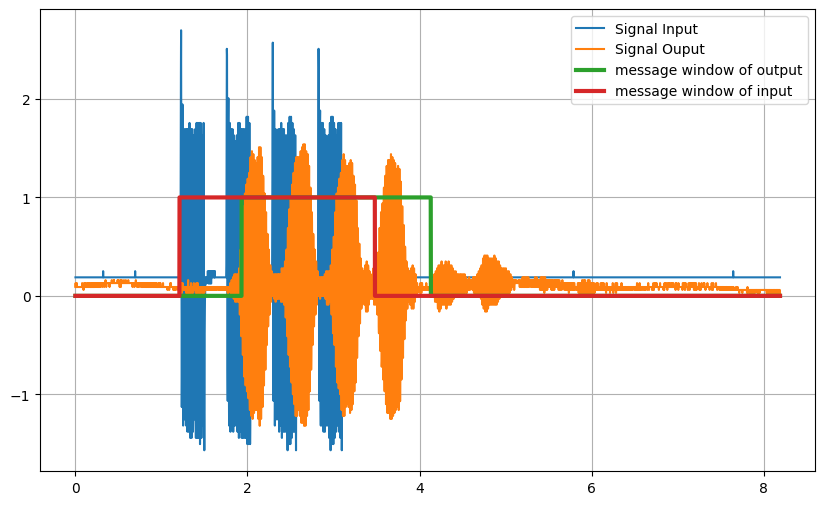

In [15]:
sample_num_out = 2
sample_num_in = 1

channel_out = None
clock_out = 0
size_out = 0
units_out = None
sample_out = samples[sample_num_out]  # take the 4 th sample for example
samp_path_out = sig_path + "/" + sample_out
f_out = open(samp_path_out)
f_raw_out = f_out.read()
volts_out, channel_out, clock_out, size_out, units_out = sample_formating(f_raw_out, channel_out, clock_out, size_out, units_out)

channel_in = None
clock_in = 0
size_in = 0
units_in = None
sample_in = samples[sample_num_in]  # take the 4 th sample for example
samp_path_in = sig_path + "/" + sample_in
f_in = open(samp_path_in)
f_raw_in = f_in.read()
volts_in, channel_in, clock_in, size_in, units_in = sample_formating(f_raw_in, channel_in, clock_in, size_in, units_in)

sampling_rate_in = 1 / clock_in
sampling_rate_out = 1 / clock_out

time_in = np.arange(0, len(volts_in) / sampling_rate_in, 1 / sampling_rate_in)
time_out = np.arange(0, len(volts_out) / sampling_rate_out, 1 / sampling_rate_out)


trigger, normalize, binary_in = rms_thresh(volts_in) # trigger, normalize are not usable and will be used on other parts
bit_len_in = detect_jump(np.nonzero(binary_in)[0])
# Find the indices of non-zero elements
non_zero_indices_in = np.nonzero(binary_in)
# Extract the first index of a non-zero element
first_non_zero_index_in = non_zero_indices_in[0][0]

trigger, normalize, binary_out = rms_thresh(volts_out) # trigger, normalize are not usable and will be used on other parts
bit_len_out = detect_jump(np.nonzero(binary_out)[0])
# Find the indices of non-zero elements
non_zero_indices_out = np.nonzero(binary_out)
# Extract the first index of a non-zero element
first_non_zero_index_out = non_zero_indices_out[0][0]

time_delay = np.abs(time_out[first_non_zero_index_out] - time_in[first_non_zero_index_in])
print("the time delay is: {}".format(time_delay))

volts_out = 100 * volts_out

heaviside_values_in = np.heaviside(time_in - time_in[first_non_zero_index_in], 1) - + \
                      np.heaviside(time_in - (time_in[first_non_zero_index_in] + 8*bit_len_in*clock), 1)

heaviside_values_out = np.heaviside(time_in - (1.2 + time_delay), 1) - np.heaviside(time_in - (3.4 + time_delay), 1)

plt.figure(figsize=(10,6))
plt.plot(time_in, volts_in, label="Signal Input")
plt.plot(time_out, volts_out, label="Signal Ouput")
plt.plot(time_in, heaviside_values_out, label="message window of output", linewidth=3)
plt.plot(time_in, heaviside_values_in, label="message window of input", linewidth=3)
plt.legend()
plt.grid()

**sample extracted data**

In [16]:
bits_str = samp_path.split("/")[-1].split("_")[0]

try:
  print("the message: " + binary_to_ascii(bits_str))
except:
  print("no binary representation")

if "_intput" in sample:
  bit_len = bit_len_in
  non_zero_indices = first_non_zero_index_in
else:
  bit_len = bit_len_out
  non_zero_indices = first_non_zero_index_out

print("sample file is:", sample)
print("sampled bits: " + bits_str)
print("the time stamp is: " + str(clock))
print("the size is: " + str(size))

the message: m
sample file is: 1101101_output.txt
sampled bits: 1101101
the time stamp is: 0.002
the size is: 4096


**The Signal**

The peak to peak Voltage and the binary representation calculated using RMS method

Peak-to-Peak Voltage: 0.019755503341687554


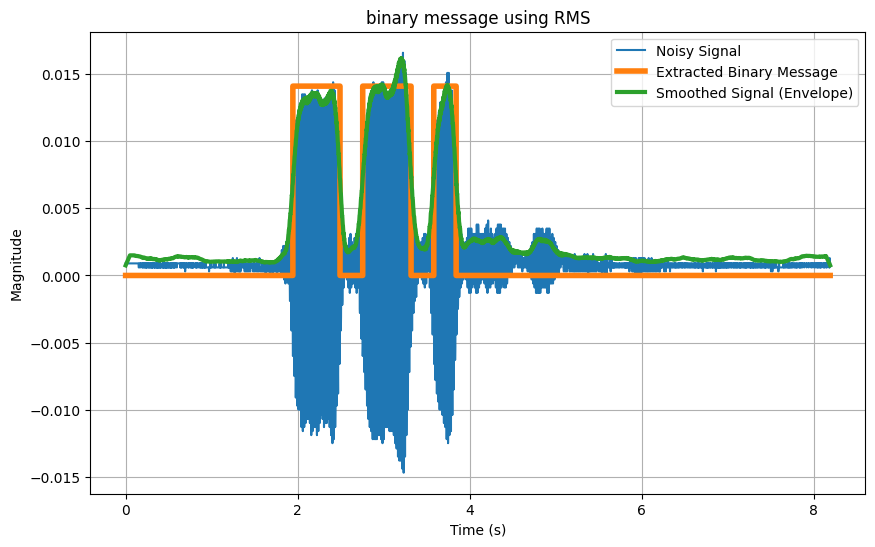

In [17]:
trigger, normalize, binary_extracted = rms_thresh(volts)
# Find all positive peaks above the threshold
positive_peaks = volts[volts > trigger]

# Find all negative troughs below the negative of the threshold
negative_troughs = volts[volts < -trigger]

# Calculate the average of positive peaks and negative troughs
avg_positive_peak = np.mean(positive_peaks)
avg_negative_trough = np.mean(negative_troughs)

# Calculate peak-to-peak voltage
peak_to_peak_voltage = avg_positive_peak - avg_negative_trough

print("Peak-to-Peak Voltage:", peak_to_peak_voltage)

# Create time array based on the sampling rate
sampling_rate = 1 / clock  # 500 Hz
time = np.arange(0, len(volts) / sampling_rate, 1 / sampling_rate)

# Plotting the original noisy signal and the extracted binary message
plt.figure(figsize=(10,6))
plt.plot(time, volts, label="Noisy Signal")
plt.step(time, binary_extracted * normalize, where="post", label="Extracted Binary Message", linewidth=4)

rectified_signal = np.abs(volts)
smoothed_signal = np.convolve(rectified_signal, np.ones(50) / 30, mode='same')  # Low-pass filtering
plt.plot(time, smoothed_signal, label='Smoothed Signal (Envelope)', linewidth=3)

plt.xlabel('Time (s)')
plt.ylabel('Magnitude')
plt.title('binary message using RMS')
plt.grid()
plt.legend()
plt.show()


Idea for analyzing the signal - we have to initiate a starting message (a sequance of bits) and also an ending message so we will know to catch a window of time with contains the message. than we can take the binary_extracted and divide it by the number of bits in the message.
so first in the header we need to define the message size. this way we will be able to know where to stop (so by choosing a message size we dont really need a an ending message).
and idea for a starting message (meaning, start lisning) is UUUU (lots of 1010101...)


the sample file is: 1101101_output.txt
the recivied message is: 11011010


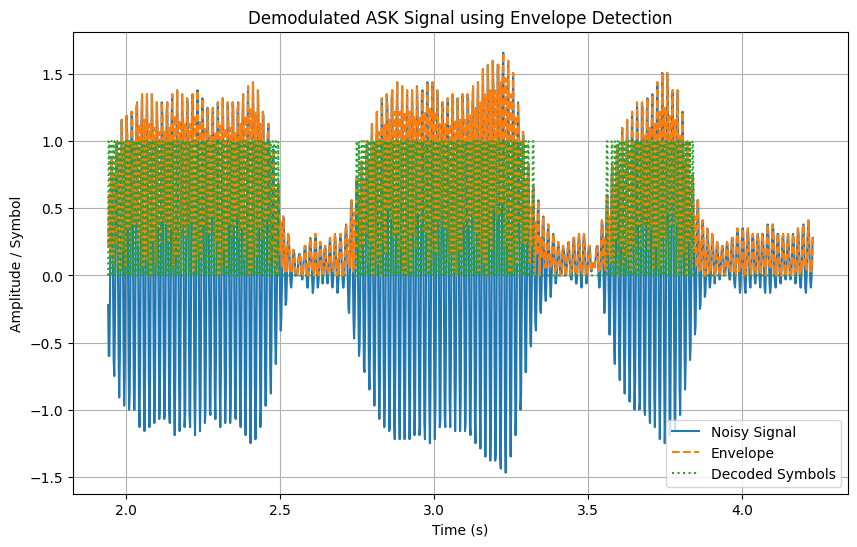

In [10]:
time_max = len(volts) / sampling_rate
message_size_bits = 8

# window shapes - needs to be modified according to the type of signal (input/output)
down_bound = non_zero_indices
up_bound = non_zero_indices + message_size_bits * bit_len
time_decode = time[down_bound:up_bound]
volts_decode = volts[down_bound:up_bound]

# Apply envelope detection (absolute value) to the noisy signal
envelope = np.abs(volts_decode)

# Set a threshold to determine binary symbols
threshold = 0.35 * np.max(volts)  # Adjust this threshold based on your signal characteristics
detected_symbols = (envelope > threshold).astype(int)

# Decode the symbols (assuming 1 represents high level and 0 represents low level)
decoded_signal = np.repeat(detected_symbols, len(volts_decode) // len(detected_symbols))

# splitting the message
decoded_signal_arr = np.array_split(decoded_signal, message_size_bits)

# resolving the message
decision_thresh = 0.3
message = []
for arr in decoded_signal_arr:
  num = np.mean(arr)
  # print(num)
  message.append(str(int(np.ceil(num) if num >= decision_thresh else np.round(num))))

print("the sample file is:", sample)
print("the recivied message is: {}".format("".join(message)))

# Plot the original noisy signal, envelope, and decoded symbols
plt.figure(figsize=(10, 6))
plt.plot(time_decode, 100*volts_decode, label='Noisy Signal')
plt.plot(time_decode, 100*envelope, label='Envelope', linestyle='dashed')
plt.plot(time_decode, decoded_signal, label='Decoded Symbols', linestyle='dotted')
plt.title("Demodulated ASK Signal using Envelope Detection")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude / Symbol")
plt.grid(True)
plt.legend()
plt.show()

**calculations of frequancies**

plotting fft
finding the carrier frequancy

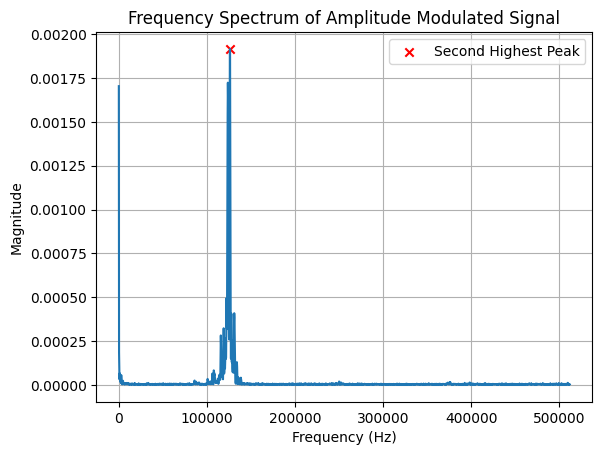

the carrier frequancy is: 126250.0


In [ ]:
# Calculate the FFT of the signal
bit_rate = size / clock # Sampling rate in Hz
yf = np.fft.fft(volts)
xf = fftfreq(size, 2/bit_rate)[:size//2] # multiply by two because of only positives

# Plot the magnitude spectrum
plt.plot(xf, 2.0/size * np.abs(yf[0:size//2]))
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.title('Frequency Spectrum of Amplitude Modulated Signal')
plt.grid()

# Get the indices that would sort the array in descending order
sorted_indices = np.argsort(np.abs(yf[0:size//2]))[::-1]

# Sort the array and the corresponding indices list
sorted_data = yf[sorted_indices]
sorted_indices_list = sorted_indices.tolist()

if sorted_indices_list[0]:
  max_index = sorted_indices_list[0]
else:
  max_index = sorted_indices_list[1]

highest_peak_frequency = xf[max_index]
amp_val = 2.0/size * np.abs(yf[0:size//2])[max_index]

# Highlight the second highest peak
plt.scatter(highest_peak_frequency, amp_val, color='red', marker='x', label='Second Highest Peak')

plt.legend()
plt.show()

print("the carrier frequancy is: " + str(highest_peak_frequency))